In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function for CLAHE application
def apply_clahe(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(image)

# Matched filter function
def matched_filter(image, kernel_sizes=[9, 15, 21], sigma=2, num_angles=24, wavelengths=[10, 15], gammas=[0.5, 1]):
    filtered_images = []
    for kernel_size in kernel_sizes:
        for angle in range(num_angles):
            theta = np.deg2rad(angle * 180 / num_angles)
            for wavelength in wavelengths:
                for gamma in gammas:
                    kernel = cv2.getGaborKernel((kernel_size, kernel_size), sigma, theta, wavelength, gamma, 0, ktype=cv2.CV_32F)
                    filtered_image = cv2.filter2D(image, cv2.CV_32F, kernel)
                    filtered_images.append(filtered_image)
    combined_image = np.max(np.array(filtered_images), axis=0)
    return combined_image

# Function to display the image
def plot_image(image, title="Image"):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Preprocess image function
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image {image_path}")
        return None

    # Step 1: Extract the green channel
    green_channel = image[:, :, 1]

    # Step 2: Apply Laplacian sharpening
    log_image = cv2.Laplacian(green_channel, cv2.CV_64F)
    log_image = np.uint8(255 * (log_image - np.min(log_image)) / (np.max(log_image) - np.min(log_image)))

    # Step 3: Apply CLAHE
    clahe = apply_clahe(log_image)

    # Step 4: Apply matched filter
    matched = matched_filter(clahe, num_angles=10, wavelengths=[10], gammas=[0.5, 1, 2])
    matched = cv2.normalize(matched, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Step 5: Apply Gaussian blur for unsharp masking
    blurred = cv2.GaussianBlur(matched, (7, 7), 10.0)
    unsharp_image = cv2.addWeighted(matched, 1.5, blurred, -0.5, 0)

    # Step 6: Apply Non-Local Means Filtering
    non_local_means_filtered = cv2.fastNlMeansDenoising(matched, None, h=3, templateWindowSize=3, searchWindowSize=50)

    # Step 7: Apply morphological closing
    kernel = np.ones((3, 3), np.uint8)
    closed_image = cv2.morphologyEx(non_local_means_filtered, cv2.MORPH_CLOSE, kernel)
    closed_image = cv2.bitwise_not(closed_image)

    # Step 8: Apply adaptive thresholding
    adaptive_thresh_mean = cv2.adaptiveThreshold(
        closed_image, 
        255, 
        cv2.ADAPTIVE_THRESH_MEAN_C, 
        cv2.THRESH_BINARY, 
        3, 
        2  
    )

    # Step 9: Invert the image for connected component analysis
    inverted = cv2.bitwise_not(adaptive_thresh_mean)
    num_labels, labels_im = cv2.connectedComponents(inverted)
    output_image = np.zeros_like(inverted)
    min_size = 15
    for label in range(1, num_labels):  
        component_size = np.sum(labels_im == label)
        if component_size >= min_size:
            output_image[labels_im == label] = 255

    return output_image

In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Define paths and labels
dataset_dir = r"C:\projects\ip\datasets"
disease_folders = {
    'N': 'normal',
    'D': 'diabetes',
    'G': 'glaucoma',
    'C': 'cataract',
    'A': 'ageDegeneration',
    'H': 'hypertension',
    'M': 'myopia',
    'O': 'others'
}

# Initialize lists to store file paths and labels
file_paths = []
labels = []

# Load images and assign labels
for label, folder_name in disease_folders.items():
    folder_path = os.path.join(dataset_dir, folder_name)
    if os.path.isdir(folder_path):
        for filename in os.listdir(folder_path):
            if filename.endswith(('.png', '.jpg', '.jpeg')):
                file_paths.append(os.path.join(folder_path, filename))
                labels.append(label)

# Convert labels to numeric values
label_index = {label: idx for idx, label in enumerate(disease_folders.keys())}
numeric_labels = [label_index[label] for label in labels]

# Convert to DataFrame for easy manipulation (optional)
data = pd.DataFrame({
    'file_path': file_paths,
    'label': numeric_labels
})


In [3]:
# Split data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(
    data['file_path'], data['label'], test_size=0.2, random_state=42, stratify=data['label']
)


In [4]:
def preprocess_images(file_paths):
    images = []
    count=0
    for file_path in file_paths:
        # Use preprocess_image function to process each image
        image = preprocess_image(file_path)
        images.append(image)
        print(count)
        count+=1
        '''if count==20:
            break'''
    return np.array(images, dtype="float32")


In [5]:
data[data['label']==7]

,file_path,label
5684,C:\projects\ip\datasets\others\image0.png,7
5685,C:\projects\ip\datasets\others\image1.png,7
5686,C:\projects\ip\datasets\others\image10.png,7
5687,C:\projects\ip\datasets\others\image100.png,7
5688,C:\projects\ip\datasets\others\image101.png,7
...,...,...
6387,C:\projects\ip\datasets\others\image95.png,7
6388,C:\projects\ip\datasets\others\image96.png,7
6389,C:\projects\ip\datasets\others\image97.png,7
6390,C:\projects\ip\datasets\others\image98.png,7


In [6]:
from tensorflow.keras.utils import to_categorical
X_train = preprocess_images(train_data)
X_test = preprocess_images(test_data)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [7]:

# Convert labels to categorical format
y_train = to_categorical(train_labels, num_classes=len(disease_folders))
y_test = to_categorical(test_labels, num_classes=len(disease_folders))


In [8]:

#y_train=y_train[:20]
#y_test=y_test[:20]

In [9]:
import tensorflow as tf

tf.config.set_visible_devices([], 'GPU')

print("Available devices:", tf.config.list_physical_devices())


Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
# Define the CNN model
def build_model(input_shape=(224, 224, 1)):  # Single-channel input
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(len(disease_folders), activation='softmax')  # Output layer with softmax for multi-class
    ])
    return model

# Instantiate the model
model = build_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [12]:
# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=8,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)


Epoch 1/25
640/640 [==============================] - 222s 346ms/step - loss: 4.9998 - accuracy: 0.4512 - val_loss: 1.4160 - val_accuracy: 0.4902
Epoch 2/25
640/640 [==============================] - 219s 342ms/step - loss: 1.2035 - accuracy: 0.5394 - val_loss: 1.4748 - val_accuracy: 0.4519
Epoch 3/25
640/640 [==============================] - 219s 342ms/step - loss: 0.6457 - accuracy: 0.7514 - val_loss: 1.9683 - val_accuracy: 0.4308
Epoch 4/25
640/640 [==============================] - 216s 337ms/step - loss: 0.1841 - accuracy: 0.9362 - val_loss: 3.2270 - val_accuracy: 0.4050
Epoch 5/25
640/640 [==============================] - 216s 338ms/step - loss: 0.0715 - accuracy: 0.9781 - val_loss: 3.9355 - val_accuracy: 0.4183
Epoch 6/25
640/640 [==============================] - 216s 338ms/step - loss: 0.0437 - accuracy: 0.9881 - val_loss: 4.5632 - val_accuracy: 0.3761


In [13]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Loss: {test_loss:.2f}")


40/40 [==============================] - 8s 204ms/step - loss: 1.4160 - accuracy: 0.4902
Test Accuracy: 0.49
Test Loss: 1.42


In [14]:
history.history

{'loss': [4.999834060668945,
  1.2034790515899658,
  0.6456633806228638,
  0.18412798643112183,
  0.07149969786405563,
  0.04366588965058327],
 'accuracy': [0.4512028098106384,
  0.539409339427948,
  0.7514179348945618,
  0.9362409710884094,
  0.9780950546264648,
  0.9880696535110474],
 'val_loss': [1.4160473346710205,
  1.4747860431671143,
  1.9683213233947754,
  3.2270476818084717,
  3.9355289936065674,
  4.563220024108887],
 'val_accuracy': [0.49022674560546875,
  0.45191556215286255,
  0.4308053255081177,
  0.4050039052963257,
  0.4182955324649811,
  0.37607505917549133]}

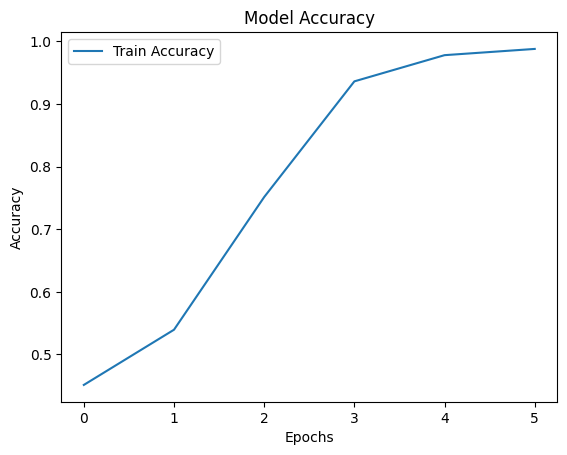

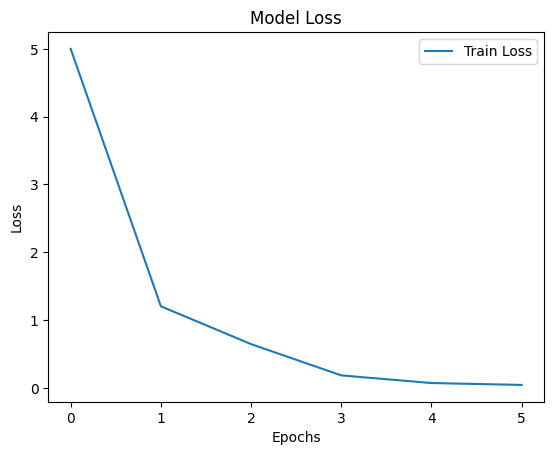

In [18]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
#plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
#plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()


In [16]:
list(disease_folders.keys())[:6]

['N', 'D', 'G', 'C', 'A', 'H']

In [17]:
from sklearn.metrics import classification_report

# Get predictions for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Print classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=list(disease_folders.keys())))


40/40 [==============================] - 9s 210ms/step
              precision    recall  f1-score   support

           N       0.48      0.92      0.64       575
           D       0.49      0.11      0.18       322
           G       0.36      0.07      0.12        57
           C       0.65      0.78      0.71        59
           A       0.00      0.00      0.00        53
           H       0.00      0.00      0.00        25
           M       0.44      0.09      0.15        46
           O       0.32      0.04      0.07       142

    accuracy                           0.49      1279
   macro avg       0.34      0.25      0.23      1279
weighted avg       0.44      0.49      0.38      1279



c:\Users\thooy\anaconda3\envs\edge\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thooy\anaconda3\envs\edge\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\thooy\anaconda3\envs\edge\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
import os
import cv2
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from skimage.feature import greycomatrix, greycoprops

# Assuming 'preprocess_image' function is defined elsewhere

# Step 1: Load and preprocess images
def load_images_with_labels(data, preprocess_fn, target_size=(224, 224)):
    original_images = []
    preprocessed_images = []
    labels = []

    for img_path, label in zip(data['file_path'], data['label']):
        # Load original image
        original_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        original_img = cv2.resize(original_img, target_size)
        original_images.append(original_img)

        # Preprocess image
        preprocessed_img = preprocess_fn(img_path)
        preprocessed_images.append(preprocessed_img)

        # Append label
        labels.append(label)

    return np.array(original_images), np.array(preprocessed_images), np.array(labels)

# Step 2: Extract features
def extract_features(images):
    features = []
    for img in images:
        # Calculate edge density using Sobel filter
        edges = cv2.Sobel(img, cv2.CV_64F, 1, 1, ksize=5)
        edge_density = np.mean(edges)

        # Calculate contrast using GLCM (gray-level co-occurrence matrix)
        glcm = greycomatrix(img, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
        contrast = greycoprops(glcm, 'contrast')[0, 0]

        # Mean intensity
        mean_intensity = np.mean(img)

        # Append features as a tuple
        features.append([edge_density, contrast, mean_intensity])
    
    return np.array(features)

# Load data and preprocess
original_images, preprocessed_images, labels = load_images_with_labels(data, preprocess_image)

# Extract features from original and preprocessed images
original_features = extract_features(original_images)
preprocessed_features = extract_features(preprocessed_images)

# Step 3: Statistical Analysis
def perform_statistical_analysis(orig_features, preproc_features, labels):
    df = pd.DataFrame({
        'label': labels,
        'orig_edge_density': orig_features[:, 0],
        'preproc_edge_density': preproc_features[:, 0],
        'orig_contrast': orig_features[:, 1],
        'preproc_contrast': preproc_features[:, 1],
        'orig_intensity': orig_features[:, 2],
        'preproc_intensity': preproc_features[:, 2]
    })

    # Compare feature distributions between original and preprocessed images per class
    results = []
    for disease in np.unique(labels):
        disease_df = df[df['label'] == disease]

        # Perform t-tests on each feature between original and preprocessed images
        for feature in ['edge_density', 'contrast', 'intensity']:
            orig_feature = disease_df[f'orig_{feature}']
            preproc_feature = disease_df[f'preproc_{feature}']
            t_stat, p_value = ttest_ind(orig_feature, preproc_feature)
            results.append({
                'Disease': disease,
                'Feature': feature,
                'T-statistic': t_stat,
                'P-value': p_value,
                'Significant': p_value < 0.05  # True if significant at 5% level
            })

    results_df = pd.DataFrame(results)
    return results_df

# Perform statistical analysis
analysis_results = perform_statistical_analysis(original_features, preprocessed_features, labels)
print("Statistical Analysis Results:")
print(analysis_results)

# Step 4: Baseline Model Comparison
def baseline_model_comparison(orig_features, preproc_features, labels):
    X_train_orig, X_test_orig, y_train, y_test = train_test_split(orig_features, labels, test_size=0.2, random_state=42)
    X_train_preproc, X_test_preproc, _, _ = train_test_split(preproc_features, labels, test_size=0.2, random_state=42)

    # Train RandomForestClassifier on original features
    model_orig = RandomForestClassifier()
    model_orig.fit(X_train_orig, y_train)
    y_pred_orig = model_orig.predict(X_test_orig)
    accuracy_orig = accuracy_score(y_test, y_pred_orig)

    # Train RandomForestClassifier on preprocessed features
    model_preproc = RandomForestClassifier()
    model_preproc.fit(X_train_preproc, y_train)
    y_pred_preproc = model_preproc.predict(X_test_preproc)
    accuracy_preproc = accuracy_score(y_test, y_pred_preproc)

    return accuracy_orig, accuracy_preproc

# Run baseline model comparison
accuracy_orig, accuracy_preproc = baseline_model_comparison(original_features, preprocessed_features, labels)
print(f"Baseline Model Accuracy - Original Features: {accuracy_orig:.2f}")
print(f"Baseline Model Accuracy - Preprocessed Features: {accuracy_preproc:.2f}")


ImportError: cannot import name 'greycomatrix' from 'skimage.feature' (c:\Users\thooy\anaconda3\envs\edge\lib\site-packages\skimage\feature\__init__.py)